DB: Analytical solution test 2
=====

3D example of known pressure solution
----

Comparison of a 3D pressure resulting from the ``underworld`` solver to the analyical solution for a unit square with viscosity $\nu = 1$ and the exact solution given by the velocities $\mathbf{u} = (u_1, u_2, u_3)$ and pressure $p$ (Dohrmann and Bochev 2004):

$$
\begin{eqnarray}
u_1 &=& x+x^2+xy+x^3y \\
u_2 &=& y+xy+y^2+x^2y^2 \\
u_3 &=& -2z-3xz-3yz-5x^2yz \\
p   &=& xyz+x^3y^3z-\frac{5}{32}
\end{eqnarray}
$$

with boundary conditions $\mathbf{u}$ given by the above equations on the boundaries and subject to the pressure constraint $\int_\Omega p(\mathbf{x})d\Omega = 0$ where $\Omega$ denotes the simulation domain. The body forces $\mathbf{f}$ are found by solving
$$
\begin{equation}
-\nu\nabla^2\mathbf{u} + \nabla p = \mathbf{f}
\end{equation}
$$
using the exact solutions. The body forces along with the velocities are used as inputs to the ``underworld`` Stokes solver to compare the resulting pressure against the exact solution.

**References**

1. C. R. Dohrmann and P. B. Bochev, A stabilized finite element method for the Stokes problem based on polynomial pressure projections, (1989) 46, 183-201
http://onlinelibrary.wiley.com/doi/10.1002/fld.752/full



In [1]:
#%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer

import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab

Setup mesh conditions
----

Change resolution parameters

In [2]:
meshX = 16
meshY = 16
meshZ = 16

Create mesh objects using the same parameters as Dohrmann and Bochev 2004

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dQ1"), 
                                 elementRes  = (meshX, meshY, meshZ), 
                                 minCoord    = (0., 0., 0.), 
                                 maxCoord    = (1., 1., 1.))

velocityField = uw.mesh.MeshVariable(mesh,3)
pressureField = uw.mesh.MeshVariable(mesh.subMesh,1)

**Setup analytic functions**

Functions consist of the body force, viscosity and velocity field inputs as well as the resulting pressure, stress and strain rate fields.


In [4]:
solA = fn.analytic.SolDB3d( Beta = 4. )

**Setup initial conditions**

Set initial velocity field to be the analytical solution, but set the initial pressure field to zero. The pressure field calculated by the Stokes solver will be compared to the analytical solution at the end.

Note that the boundary condition values are also set at this point.

In [5]:
vel=solA.fn_velocity
velocityField.data[:] = vel.evaluate(mesh.data)
pressureField.data[:] = 0.

**Plot the vertical component of the body force solution**



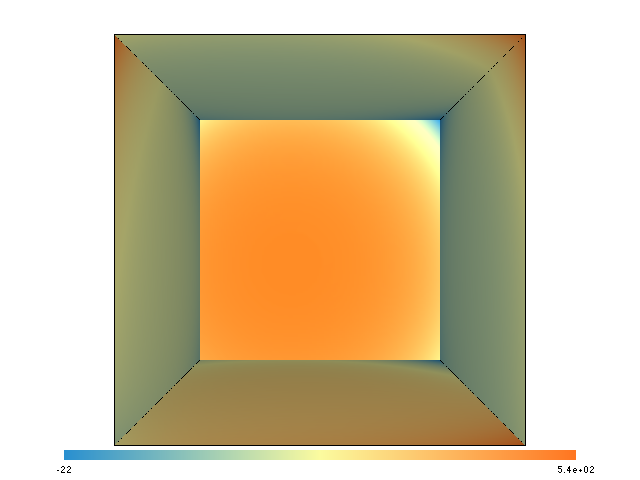

In [6]:
force = glucifer.Figure()
force.append( glucifer.objects.Surface(mesh, solA.fn_bodyforce[2]) )
force.show()

**Plot the magnitude of the velocity field**


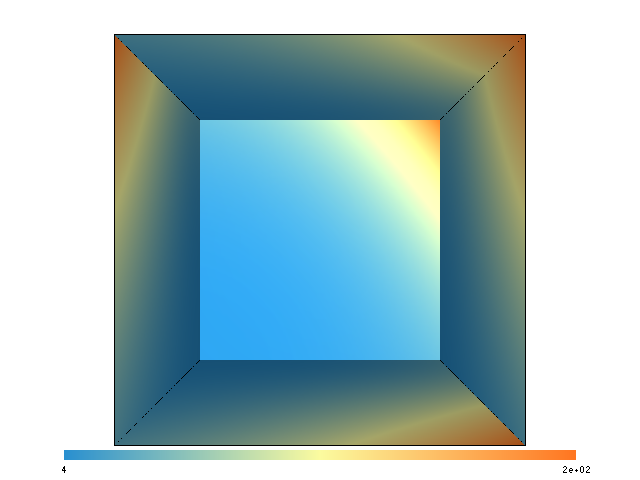

In [7]:
velMag = glucifer.Figure()
velMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField)) )
velMag.show()

**Set dirichlet boundary conditions on all walls**

In [8]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]
allWalls = iWalls + jWalls + kWalls

BC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                       indexSetsPerDof = (allWalls, allWalls, allWalls) )

Setup Stokes system
---

**Change here to test other solver options**

In [9]:
stokesSystem = uw.systems.Stokes(velocityField = velocityField,
                                 pressureField = pressureField,
                                 fn_viscosity  = solA.fn_viscosity,
                                 fn_bodyforce  = solA.fn_bodyforce,
                                 conditions    = [BC,])

solver = uw.systems.Solver( stokesSystem )

**Solve Stokes system**

This will solve for the pressure given the velocity, viscosity and body force.

In [10]:
solver.solve()

Compare ``underworld`` and analytical solutions
----

**Plot analytic solution to the pressure field**


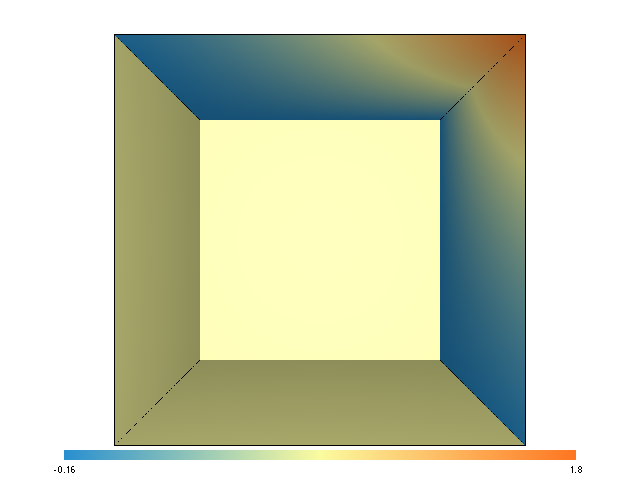

In [11]:
pA = glucifer.Figure()
pA.append( glucifer.objects.Surface(mesh, solA.fn_pressure) )
pA.show()

**Plot difference between solved pressure field and analytic solution**


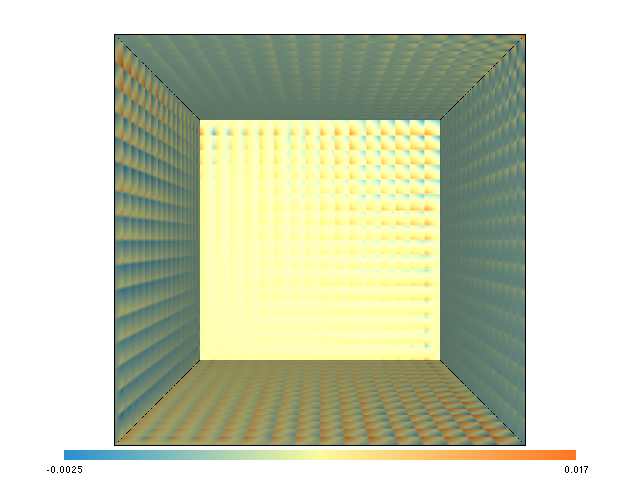

In [12]:
pDiff = glucifer.Figure()
pDiff.append( glucifer.objects.Surface(mesh, solA.fn_pressure-pressureField ) )
pDiff.show()

**Examine error across a single line**

Look at the error in the pressure field for $x=0.85$ and $z=0.0$, scaled to fit along side the exact and numerical solution.

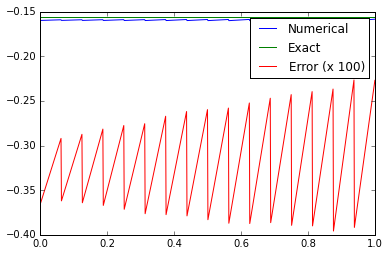

In [17]:
if(uw.nProcs()==1):
    %matplotlib inline
    import matplotlib.pyplot as mplt
    import matplotlib.pylab as pylab
    N=801
    a=np.ndarray(shape=(N,3))
    a[:,0]=0.85*np.ones(N)
    a[:,1]=np.linspace(0,1,N)
    a[:,2]=0.0
    ax=a[:,1]
    pex=solA.fn_pressure.evaluate_global( a[:,])
    y=a[:,1]
    pfd=pressureField.evaluate_global(a[:,])
    mplt.plot(y,pfd,label='Numerical')
    mplt.plot(y,pex,label='Exact')
    mplt.plot(y,100*(pfd-pex),label='Error (x 100)')
    mplt.legend()
    mplt.savefig('Pressure_Error.png')

Global error measures
-----

Work out the global rms values for the velocity error (should be very low) and the pressure error.

In [14]:
v_err = uw.utils.Integral( fn   = fn.math.dot(solA.fn_velocity-velocityField, solA.fn_velocity-velocityField), 
                           mesh = mesh )
v_sol = uw.utils.Integral( fn   = fn.math.dot(solA.fn_velocity, solA.fn_velocity), 
                           mesh = mesh )
p_err = uw.utils.Integral( fn   = fn.math.dot(solA.fn_pressure-pressureField, solA.fn_pressure-pressureField), 
                           mesh = mesh )
p_sol = uw.utils.Integral( fn   = fn.math.dot(solA.fn_pressure, solA.fn_pressure), 
                           mesh = mesh )

area    = uw.utils.Integral( fn = 1., mesh = mesh )
totalArea = area.evaluate()[0]

rms_velocity_err = math.sqrt( v_err.evaluate()[0]/totalArea )
rms_velocity_rel = math.sqrt( v_err.evaluate()[0]/v_sol.evaluate()[0] )
rms_pressure_err = math.sqrt( p_err.evaluate()[0]/totalArea )
rms_pressure_rel = math.sqrt( p_err.evaluate()[0]/p_sol.evaluate()[0] )

In [15]:
if uw.rank()==0:
    print("Pressure error = {0:.6f}%; relative error = {1:.6f}%"
          .format(rms_pressure_err*100, rms_pressure_rel*100))
    print("Velocity error = {0:.6f}%; relative error = {1:.6f}%"
          .format(rms_velocity_err*100, rms_velocity_rel*100))

Pressure error = 0.326692%; relative error = 1.429552%
Velocity error = 0.000495%; relative error = 0.000119%


**Output the pressure rms value**

Use this for quick diagnosis when checking different models

In [16]:
if uw.rank()==0:
    print rms_pressure_rel

0.0142955215898
